In [578]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv
import lib.plot.table as plttbl

import os
import math
import numpy as np

In [1092]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)
importlib.reload(plttbl)

<module 'lib.plot.table' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/table.py'>

### Load data

In [17]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
#path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path

'M06_th45/'

In [18]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

### transform frame

In [5]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields
dflow = ft.transform_flow(dflow,vshock)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


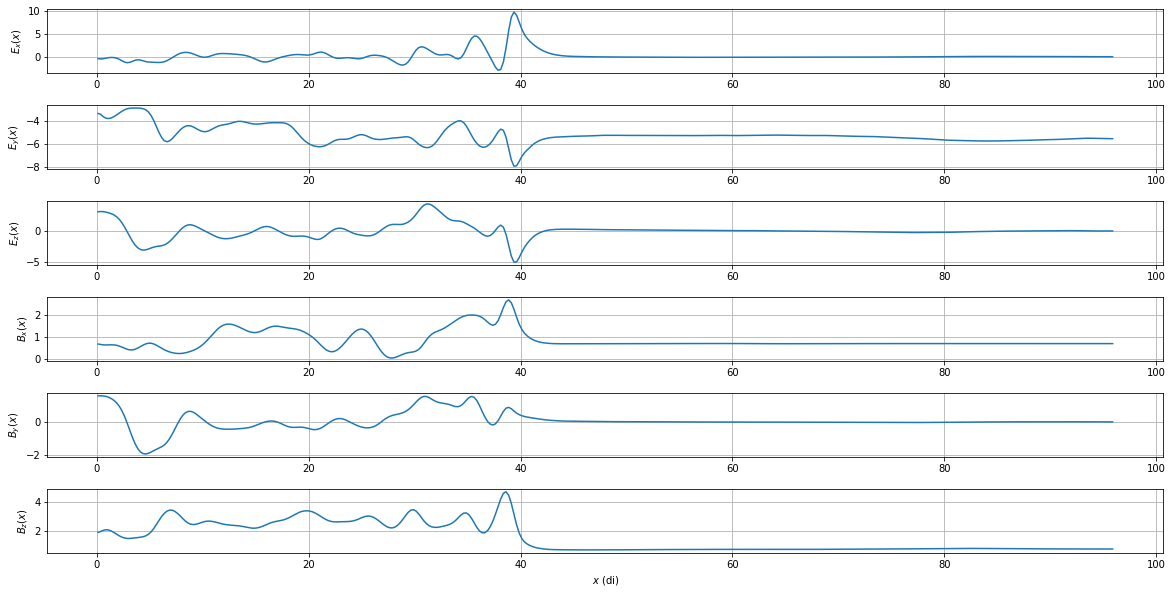

In [6]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [7]:
dfields['bz'][1,2,4]

2.046367

### select x region to analyze

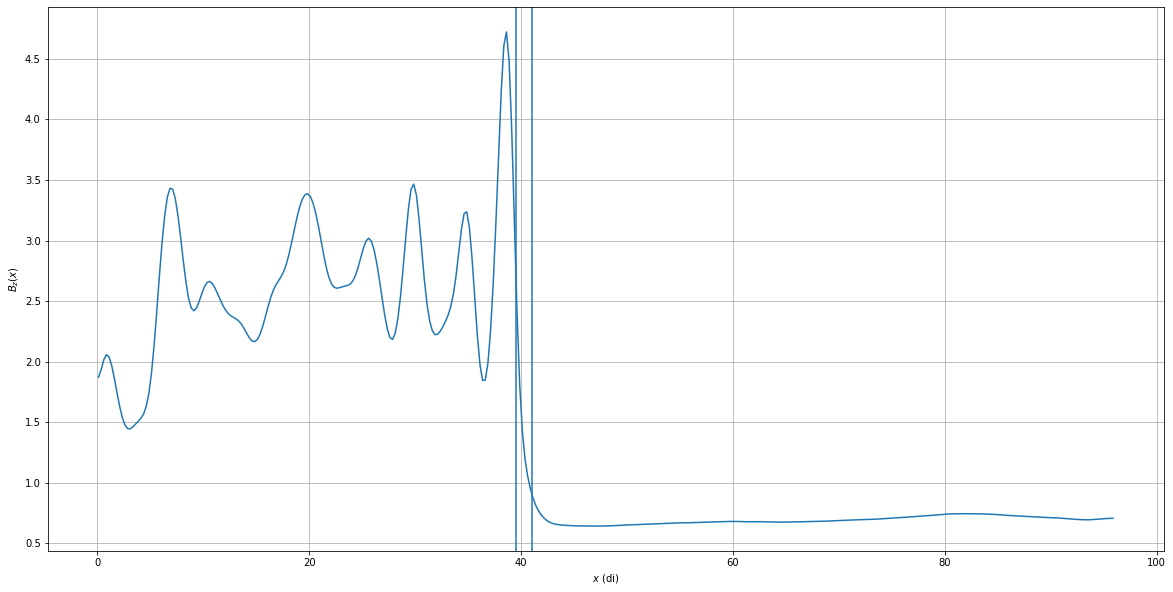

In [8]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startvalramp = 39.5#lower bound for metadata = 1 (di)
endvalramp = 41. #upper bound for metadata = 1 (di)

midrampx = (startvalramp+endvalramp)/2.
midrampidx = ao.find_nearest(dfields['bz_xx'],midrampx)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startvalramp, axvx2 = endvalramp)

### get fluctuations

In [9]:
dflow.keys()

dict_keys(['ux', 'ux_xx', 'ux_yy', 'ux_zz', 'uy', 'uy_xx', 'uy_yy', 'uy_zz', 'uz', 'uz_xx', 'uz_yy', 'uz_zz', 'id', 'Vframe_relative_to_sim'])

In [10]:
dfields['bz'][1,2,4]

2.046367

In [11]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

In [12]:
dfields['bz'][1,2,4]

2.046367

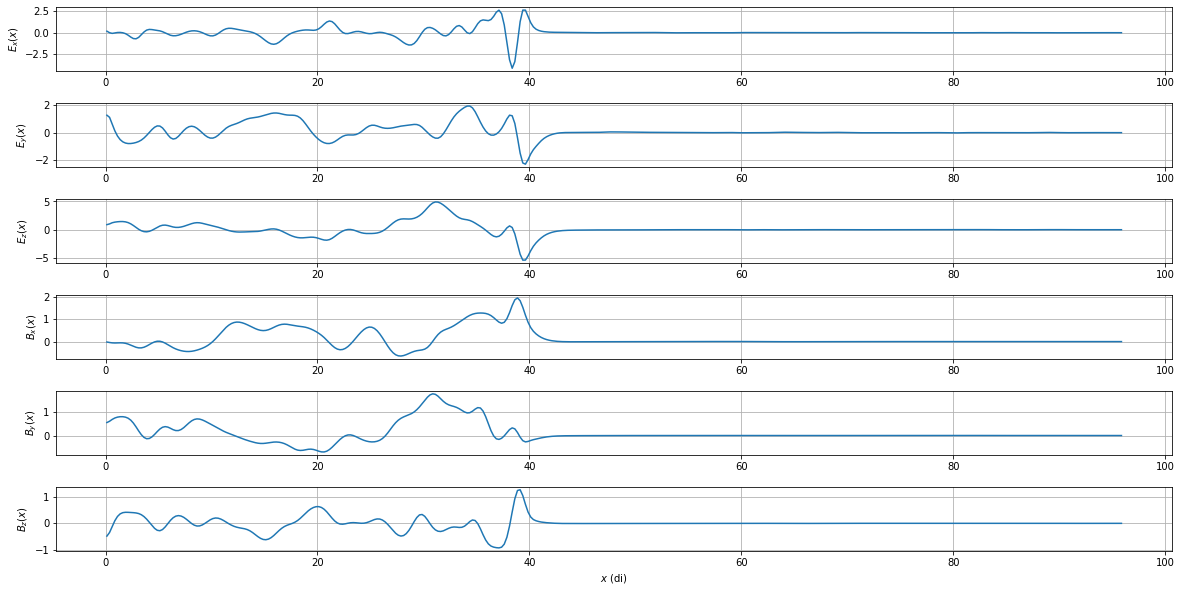

In [13]:
plt1d.plot_all_fields(dfieldsfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### get relevant subset

In [14]:
dfields['bz'][1,2,4]

2.046367

In [15]:
dfieldssubset = ao.get_field_subset(dfields,startvalramp,endvalramp,0.,12.,0.,12.)
dflowsubsset = ao.get_flow_subset(dflow,startvalramp,endvalramp,0.,12.,0.,12.)

dfieldflucsubset = ao.get_field_subset(dfieldsfluc,startvalramp,endvalramp,0.,12.,0.,12.)
dflowflucsubsset = ao.get_flow_subset(dflowfluc,startvalramp,endvalramp,0.,12.,0.,12.)

In [16]:
dfields['bz'][1,2,4]

2.046367

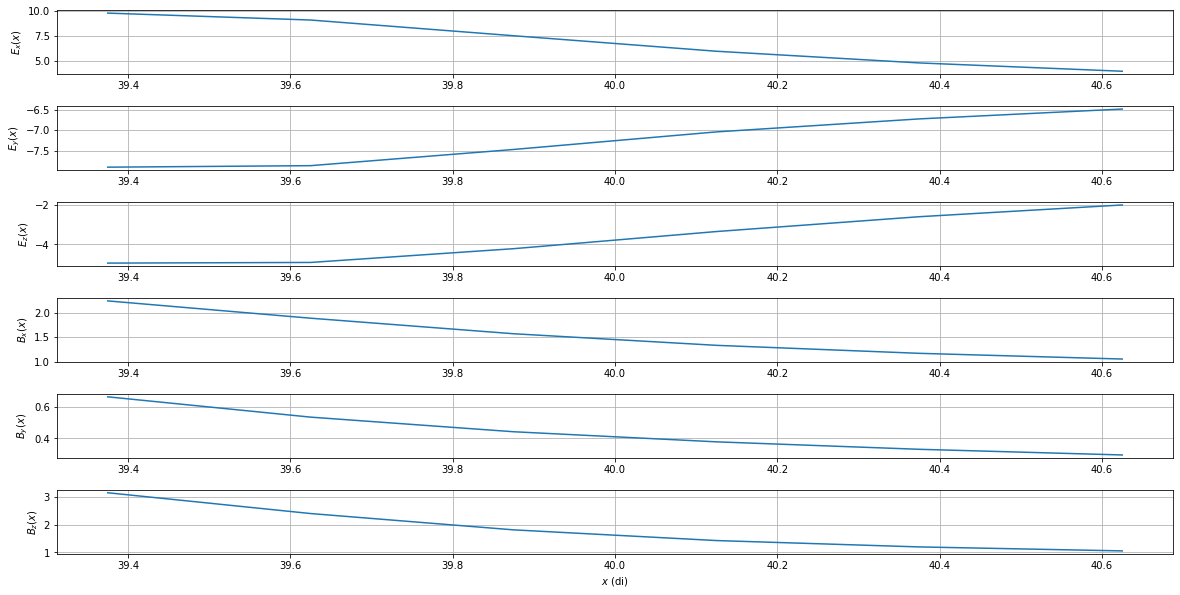

In [17]:
plt1d.plot_all_fields(dfieldssubset, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### look at average yz averaged fields

In [18]:
dfields['bz'][1,2,4]

2.046367

In [19]:
dfieldsavg = anl.get_average_fields_over_yz(dfields)

In [20]:
dfields['bz'][1,2,4]

1.7795179

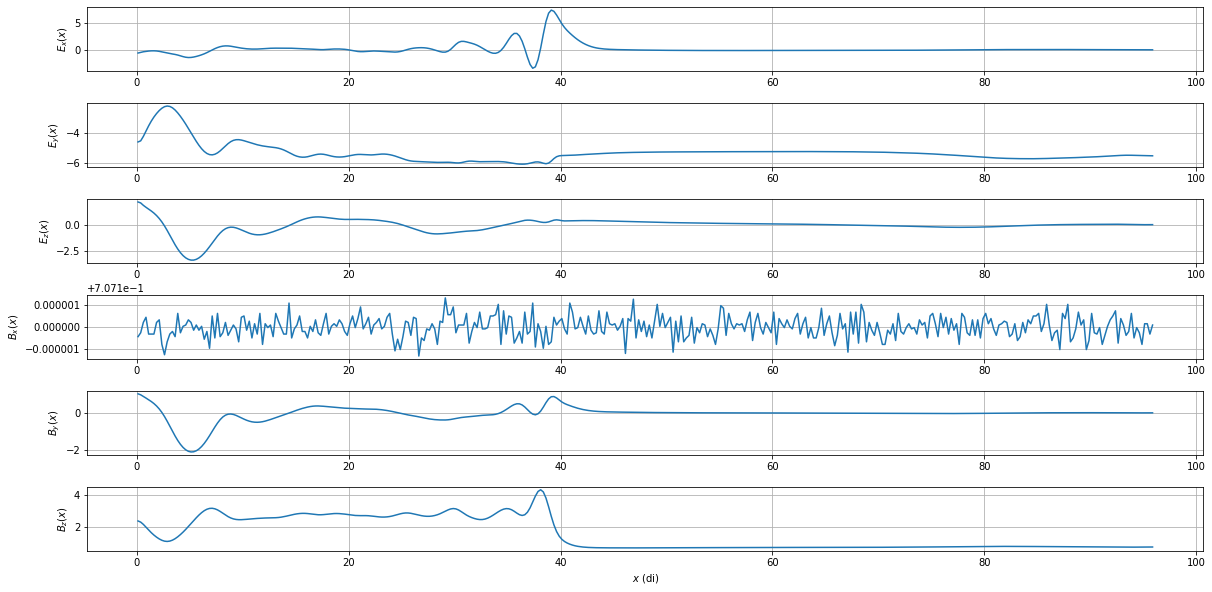

In [21]:
plt1d.plot_all_fields(dfieldsavg, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Take FFT

In [22]:
dfields['bz'][1,2,4]

1.7795179

In [23]:
fftbx = np.fft.fftn(dfieldflucsubset['bx'])
fftby = np.fft.fftn(dfieldflucsubset['by'])
fftbz = np.fft.fftn(dfieldflucsubset['bz'])
fftex = np.fft.fftn(dfieldflucsubset['ex'])
fftey = np.fft.fftn(dfieldflucsubset['ey'])
fftez = np.fft.fftn(dfieldflucsubset['ez'])
fftux = np.fft.fftn(dflowflucsubsset['ux'])
fftuy = np.fft.fftn(dflowflucsubsset['uy'])
fftuz = np.fft.fftn(dflowflucsubsset['uz'])

In [24]:
dfields['bz'][1,2,4]

1.7795179

### Test Wavelet Transform over xx

In [25]:
#first calculate Bi(x,ky,kz) (or Ei(x,ky,kz))
fieldkey = 'bz'

In [26]:
dfields['bz'][1,2,4]

1.7795179

In [27]:
#spacing in grids, needed to get wavenumber from fft
daxis0 = dfieldsfluc[fieldkey+'_zz'][1]-dfieldsfluc[fieldkey+'_zz'][0]
daxis1 = dfieldsfluc[fieldkey+'_yy'][1]-dfieldsfluc[fieldkey+'_yy'][0]

fieldfftsweepoverx = []
for xxindex in range(0,len(dfieldsfluc[fieldkey][0][0])):
    fieldslice = np.asarray(dfieldsfluc[fieldkey])[:,:,xxindex]
    kz, ky, fieldslicefft = anl.take_fft2(fieldslice,daxis0,daxis1)
    fieldfftsweepoverx.append(fieldslicefft)
fieldfftsweepoverx = np.asarray(fieldfftsweepoverx)

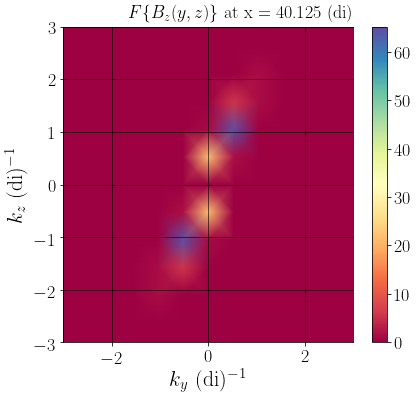

In [28]:
pltfr.plot_fft_norm(dfieldsfluc, fieldkey,'yz', takeaxisaverage=False, xxindex=midrampidx, plotlog=False,xaxislim=3,yaxislim=3) 

(Pick one of the following options to find a kyidx and kzidx that we are going to be analyzing)

##### option 1

In [29]:
#pick ky kz by using max
kyidx, kzidx = np.unravel_index(np.argmax(fieldfftsweepoverx[midrampidx], axis=None), fieldfftsweepoverx[midrampidx].shape)

##### option 2

In [30]:
# #hand pick ky, kz using above plot
# kyidx = ao.find_nearest(ky,.5)
# kzidx = ao.find_nearest(kz,1.)

In [31]:
#take slice at given ky kz
xkykzdata = fieldfftsweepoverx[:,kzidx,kyidx] #TODO: Double check if ky and kz should be flipped
ky0 = ky[kyidx]
kz0 = kz[kzidx]

In [32]:
dfields['bz'][1,2,4]

1.7795179

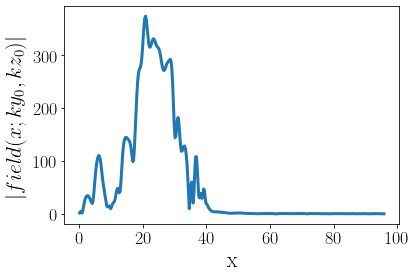

In [33]:
#plot norm
import matplotlib.pyplot as plt
temp = np.absolute(xkykzdata)
plt.figure()
plt.ylabel('$|field(x;ky_0,kz_0)|$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

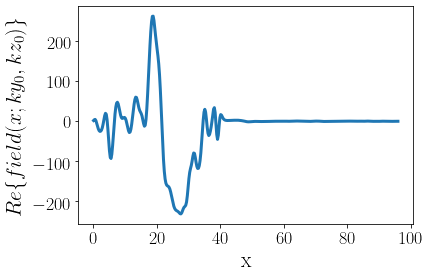

In [34]:
#plot real component
import matplotlib.pyplot as plt
temp = np.real(xkykzdata)
plt.figure()
plt.ylabel('$Re\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

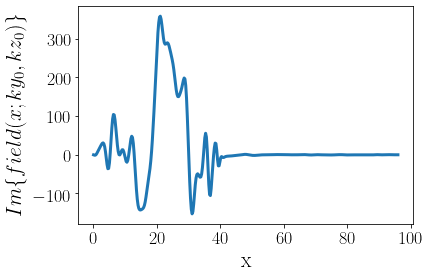

In [35]:
#plot imag component
import matplotlib.pyplot as plt
temp = np.imag(xkykzdata)
plt.figure()
plt.ylabel('$Im\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

In [36]:
dfields['bz'][1,2,4]

1.7795179

### Test Wavelet Transform over xx

In [37]:
kx, wlt = anl.wlt(dfieldsfluc[fieldkey+'_xx'],xkykzdata)

In [38]:
dfields['bz'][1,2,4]

1.7795179

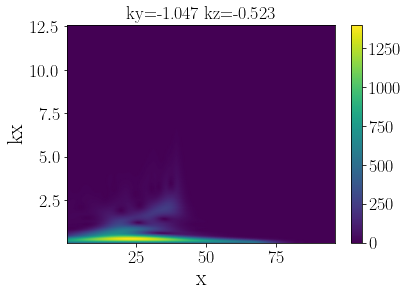

In [39]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],kx,np.abs(wlt),cmap='viridis', shading='gouraud')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.title('ky='+str(ky0)[0:6]+' kz='+str(kz0)[0:6])
flnm='ky='+str(ky0)[0:6]+'kz='+str(kz0)[0:6]+'wlt'
plt.savefig(flnm+'.png',format='png')
plt.show()

### Test routine that checks all predicted wave modes and sees if they are alfvenic

In [1081]:
#pick some test slice in the simulation
xx = 40.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

In [1082]:
xxidx = ao.find_nearest(dfields['bz_xx'],xx)

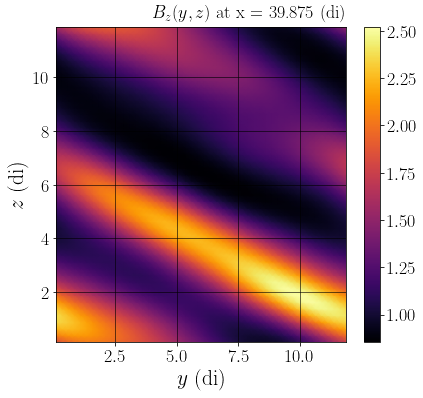

In [1083]:
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx)

In [1084]:
#(for alfvenic wave, we would expect 1,0,0)

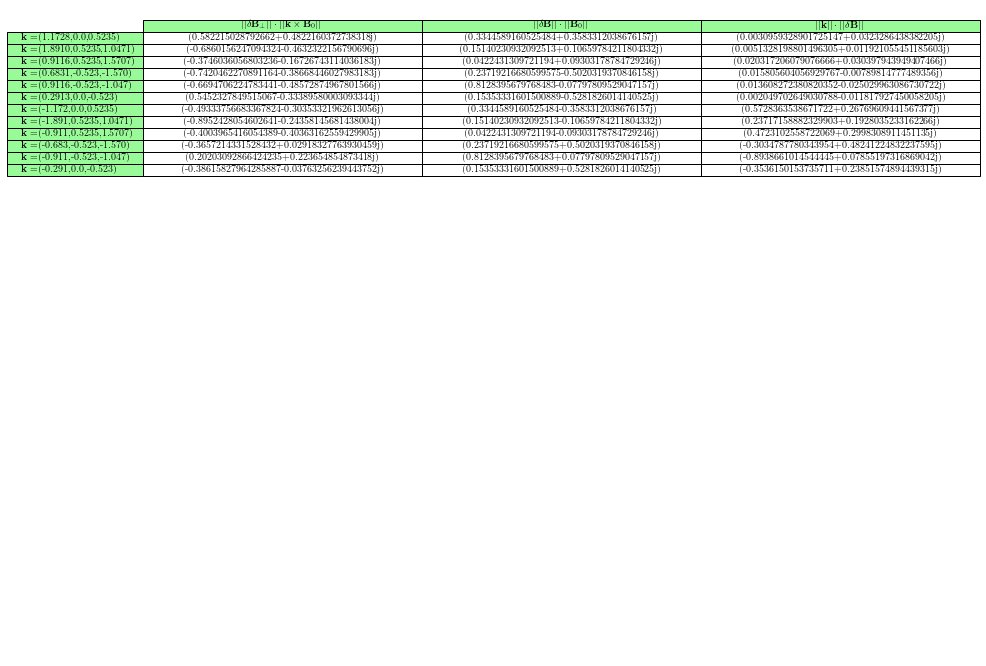

In [1093]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results = anl.alfven_wave_check(dfields,dfieldsfluc,klist,xx)

#build and make table
results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
           r'$|| \mathbf{k} || \cdot || \delta \mathbf{B} ||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

In [ ]:
# dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

# dfieldsavg = anl.get_average_fields_over_yz(dfieldsfluc)

# #build list of k's to test
# klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

# #test given k's
# results = anl.alfven_wave_check(dfieldsavg,klist,xx)

# #build and make table
# results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
# collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
#            r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
#            r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$']
# rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
# plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

### Look at spatial structure of delB dot B0 and other plotted quantities

In [1055]:
#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

dbperpdotkcrossb0list = []
dbdotb0list = []
dbdotklist = []
for i in range(0,len(dfields['bz_xx'])):
    print(str(i) + ' of ' + str(len(dfieldsfluc['bz_xx'])))
    #test given k's
    results = anl.alfven_wave_check(dfields,dfieldsfluc,[klist[0]],dfieldsfluc['bz_xx'][i])

    #build and make table
    results_vals = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
    dbperpdotkcrossb0list.append(results_vals[0][0])
    dbdotb0list.append(results_vals[0][1])
    dbdotklist.append(results_vals[0][2])
    


0 of 384
1 of 384
2 of 384
3 of 384
4 of 384
5 of 384
6 of 384
7 of 384
8 of 384
9 of 384
10 of 384
11 of 384
12 of 384
13 of 384
14 of 384
15 of 384
16 of 384
17 of 384
18 of 384
19 of 384
20 of 384
21 of 384
22 of 384
23 of 384
24 of 384
25 of 384
26 of 384
27 of 384
28 of 384
29 of 384
30 of 384
31 of 384
32 of 384
33 of 384
34 of 384
35 of 384
36 of 384
37 of 384
38 of 384
39 of 384
40 of 384
41 of 384
42 of 384
43 of 384
44 of 384
45 of 384
46 of 384
47 of 384
48 of 384
49 of 384
50 of 384
51 of 384
52 of 384
53 of 384
54 of 384
55 of 384
56 of 384
57 of 384
58 of 384
59 of 384
60 of 384
61 of 384
62 of 384
63 of 384
64 of 384
65 of 384
66 of 384
67 of 384
68 of 384
69 of 384
70 of 384
71 of 384
72 of 384
73 of 384
74 of 384
75 of 384
76 of 384
77 of 384
78 of 384
79 of 384
80 of 384
81 of 384
82 of 384
83 of 384
84 of 384
85 of 384
86 of 384
87 of 384
88 of 384
89 of 384
90 of 384
91 of 384
92 of 384
93 of 384
94 of 384
95 of 384
96 of 384
97 of 384
98 of 384
99 of 384
100 of 384

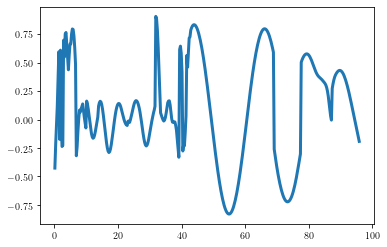

In [1056]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbperpdotkcrossb0list))
plt.show()

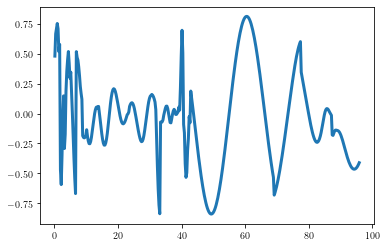

In [1057]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbperpdotkcrossb0list))
plt.show()

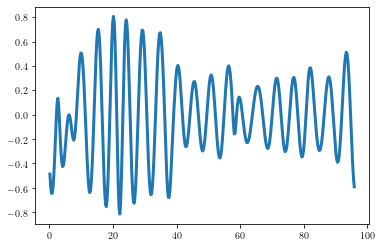

In [1058]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbdotb0list))
plt.show()

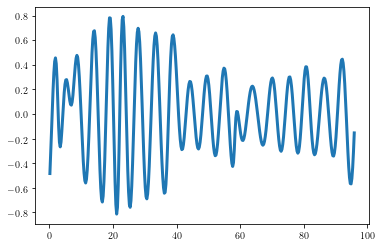

In [1059]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbdotb0list))
plt.show()

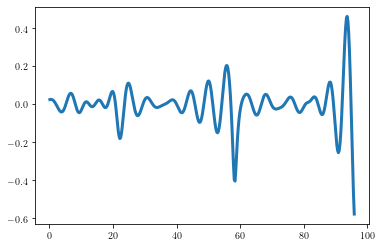

In [1060]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.real(dbdotklist))
plt.show()

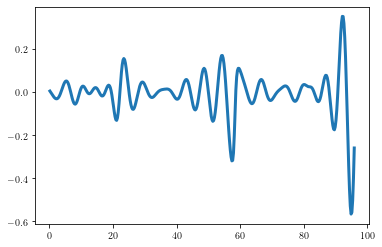

In [1061]:
plt.figure()
plt.plot(dfieldsfluc['bz_xx'],np.imag(dbdotklist))
plt.show()

In [1062]:
np.sum(dbdotklist)

(-1.1858166441162152-3.2751171709540503j)

### See what kx needs to be given some ky, kz

In [593]:
#pick some test position in the simulation
xx = 40.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

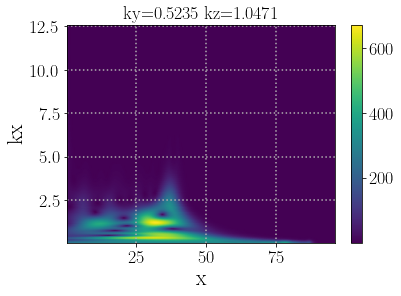

In [594]:
#TODO: generate plots related to the true part here
i = 1
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', xlim = None, ylim = None)

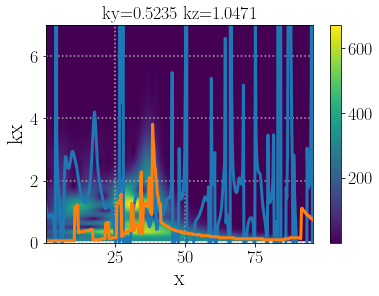

In [595]:
#plot what kx would need to be given ky kz along some 
k = [kxlist[i],kylist[i],kzlist[i]]
xxvals = []
kxvals = []
for xidx in range(0,len(dfields['bz_xx'])):
    xxidx = xidx
    delBperp = [dperpf['bx'][zzidx,yyidx,xxidx],dperpf['by'][zzidx,yyidx,xxidx],dperpf['bz'][zzidx,yyidx,xxidx]]
    kxvals.append(predict_kx(k[1],k[2],B0,delBperp))
    xxvals.append(dfields['bz_xx'][xidx])
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', plotstrongestkx = True, ylim = [0,7], xxline = xxvals, yyline = kxvals)

### Looks like we need to find local maximum instead of absolute maxima and see if any of those are alfvenic

In [499]:
wlttemp = wltplotlist[0]
xx = dfields['bz_xx']
xidx = ao.find_nearest(xx,90)
wltslice = np.abs(wlttemp[:,xidx])


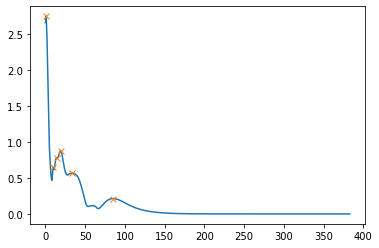

[1, 10, 14, 19, 33, 85]

In [500]:
ao.find_local_maxima(wltslice,threshold = .05,pltdebug = True)

In [785]:
ao.find_nearest([0,3,-1,4,-2,23],4.2)

3